In [1]:
import requests
import pandas as pd
import os
import glob
from datetime import datetime
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import missingno as msno


## Data Preparation

### Load Data

In [2]:
clean_hdb_df1 = pd.read_csv('Processed_Data/hdb_data_with_coords_mrt_dist_id.csv',
    parse_dates=['month', 'lease_commence_date'])

In [3]:
df = clean_hdb_df1.copy()

### Exploratory Data Analysis

=== Data Quality Report ===

1. Basic Information:
Rows: 962,946
Columns: 23

2. Data Types:
remaining_lease                float64
floor_area_sqm                 float64
storey_range                    object
street_name                     object
lease_commence_date     datetime64[ns]
month                   datetime64[ns]
flat_type                       object
resale_price                   float64
town                            object
block                           object
flat_model                      object
storey_range_min                 int64
storey_range_max                 int64
full_address                    object
Latitude                       float64
Longitude                      float64
nearest_mrt_id                  object
mrt_name                        object
mrt_latitude                   float64
mrt_longitude                  float64
mrt_road                        object
Distance_from_MRT_km           float64
transaction_id                   int64
dtype: obj

/var/folders/y_/h86dm1h150v7bstq3mkcv4gm0000gn/T/ipykernel_3611/2745395831.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

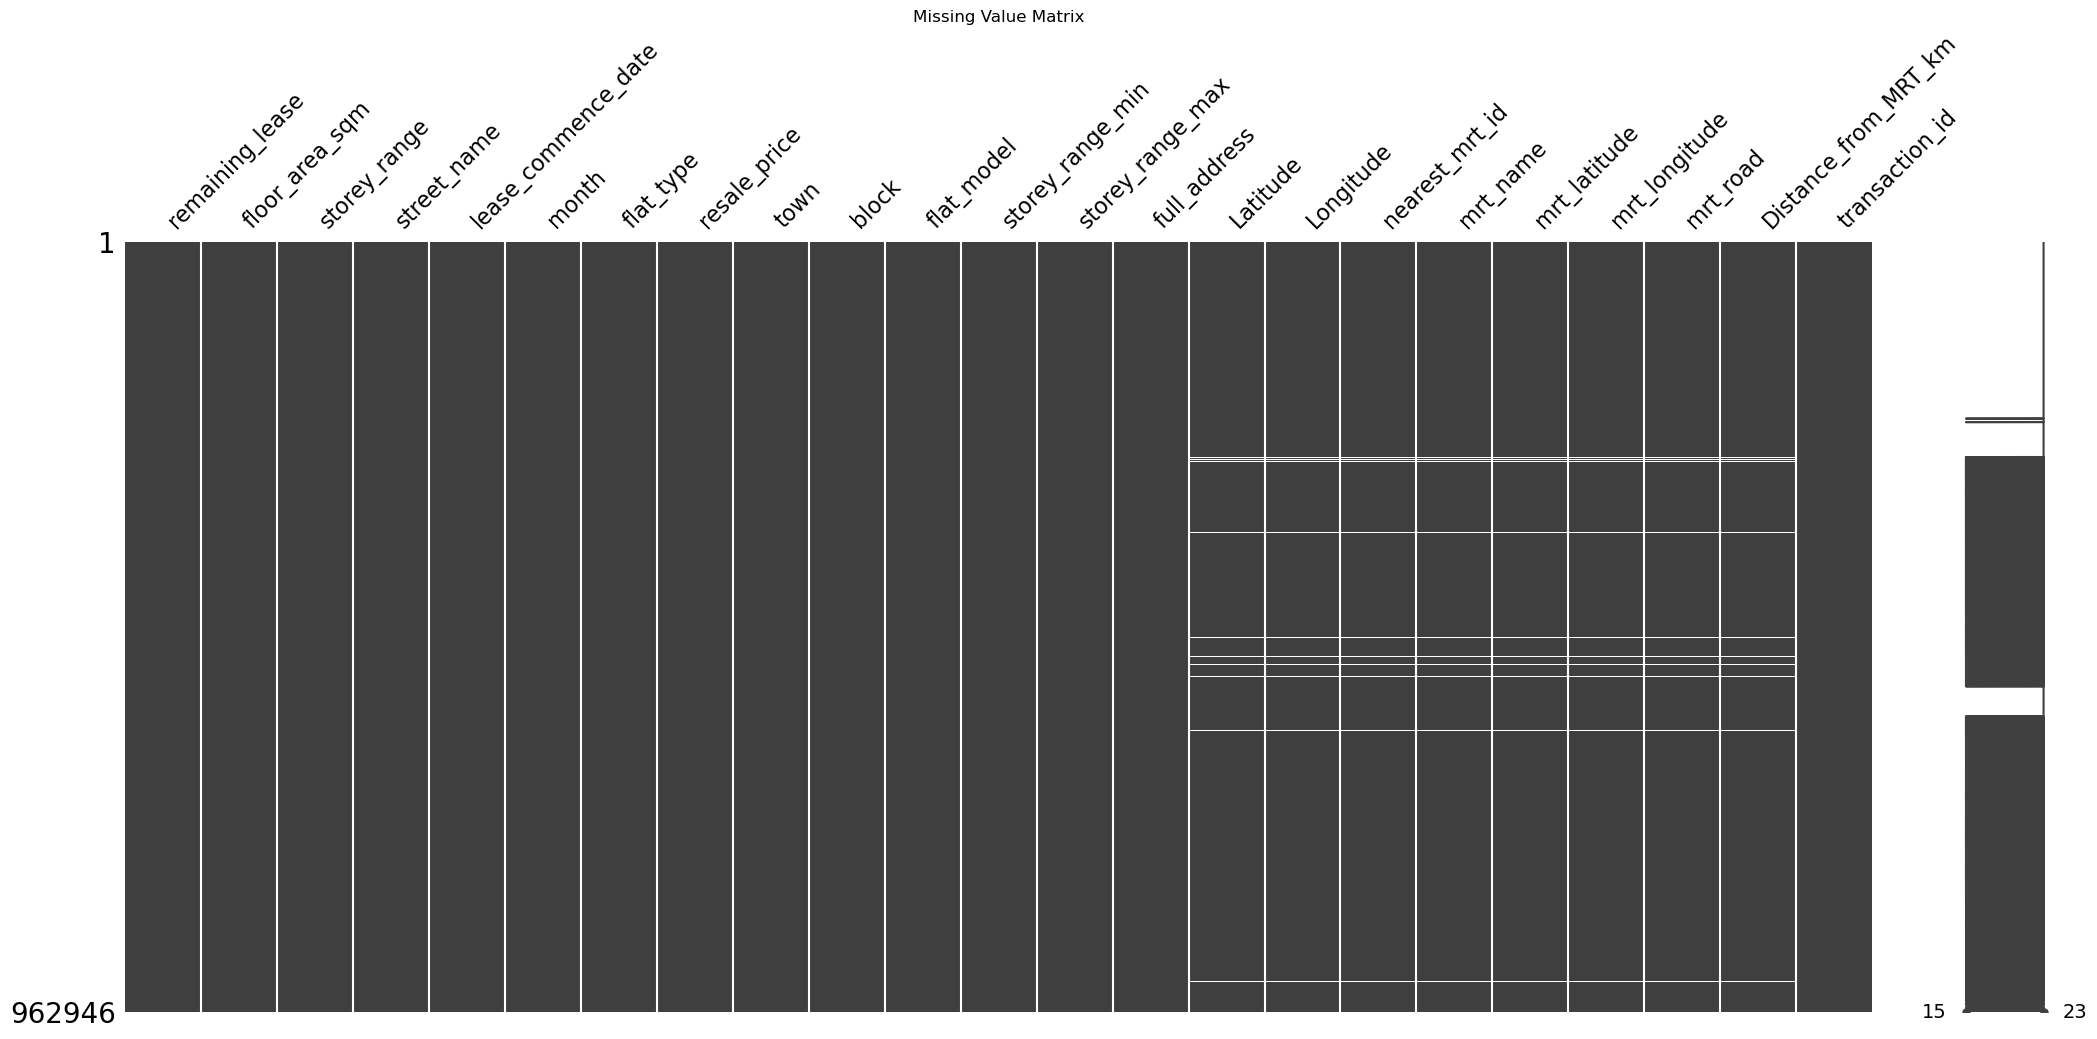

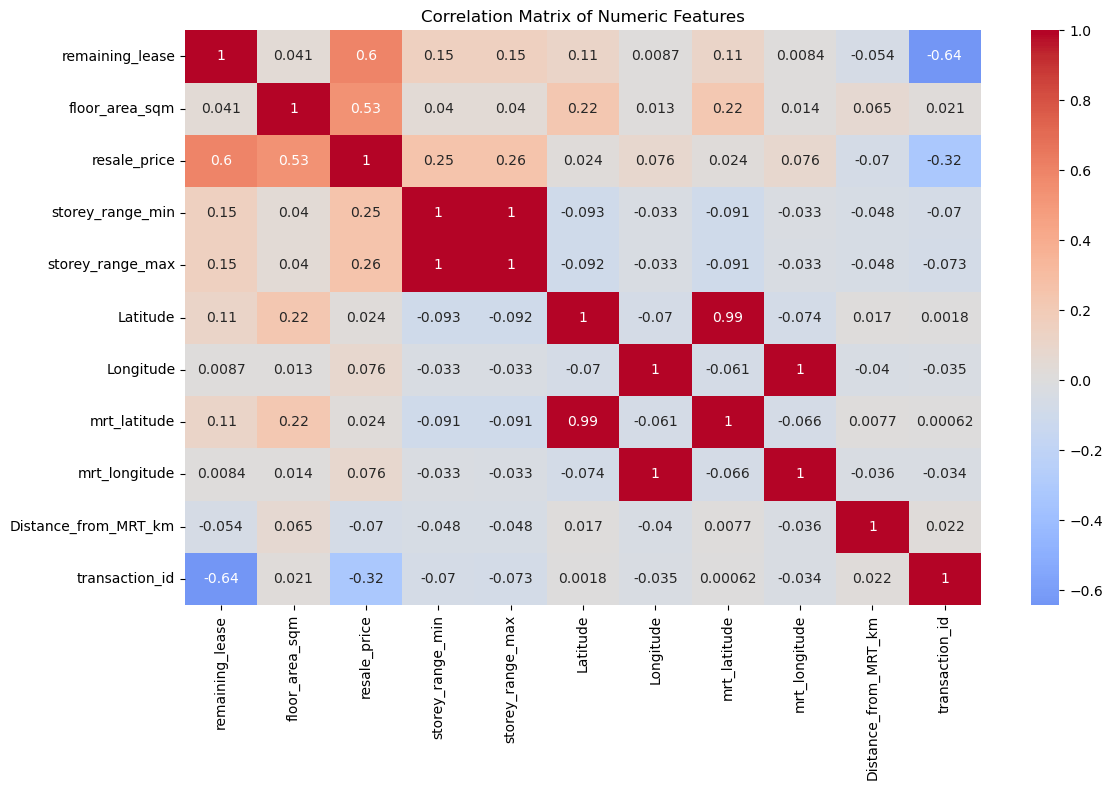

In [4]:
def check_data_quality(df):
    """
    Comprehensive data quality check for DataFrame
    """
    print("=== Data Quality Report ===\n")
    
    # Basic DataFrame Info
    print("1. Basic Information:")
    print(f"Rows: {df.shape[0]:,}")
    print(f"Columns: {df.shape[1]:,}")
    print("\n2. Data Types:")
    print(df.dtypes)
    
    # Missing Values
    print("\n3. Missing Values:")
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing,
        'Percentage': missing_pct
    })
    print(missing_df[missing_df['Missing Values'] > 0])
    
    # Infinite Values
    print("\n4. Infinite Values:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    inf_counts = {col: np.sum(~np.isfinite(df[col])) for col in numeric_cols}
    inf_df = pd.DataFrame.from_dict(inf_counts, orient='index', columns=['Count'])
    print(inf_df[inf_df['Count'] > 0])
    
    # Zero Values (for numeric columns)
    print("\n5. Zero Values (numeric columns):")
    zero_counts = {col: (df[col] == 0).sum() for col in numeric_cols}
    zero_pct = {col: (zero_counts[col] / len(df)) * 100 for col in numeric_cols}
    zeros_df = pd.DataFrame({
        'Zero Count': zero_counts,
        'Zero Percentage': zero_pct
    })
    print(zeros_df[zeros_df['Zero Count'] > 0])
    
    # Unique Values (for categorical columns)
    print("\n6. Unique Values (categorical columns):")
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        n_unique = df[col].nunique()
        print(f"{col}: {n_unique:,} unique values")
    
    # Memory Usage
    print("\n7. Memory Usage:")
    memory_usage = df.memory_usage(deep=True).sum() / 1024**2  # in MB
    print(f"Total Memory Usage: {memory_usage:.2f} MB")

# Run the analysis
check_data_quality(df)

#Visual missing value analysis using missingno
plt.figure(figsize=(10, 6))
msno.matrix(df)
plt.title("Missing Value Matrix")
plt.tight_layout()
plt.show()

# Optional: Correlation heatmap for numeric columns
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), 
            annot=True, 
            cmap='coolwarm', 
            center=0)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

Visualizing distribution of flat prices

In [5]:
df["year"] = df["month"].dt.year
df["year_group"] = df["year"].astype(str)

# --- Create 4-year bins automatically from 1990 to 2025 ---
start_year = 1990
end_year = 2025
bin_edges = list(range(start_year, end_year + 1, 4))  # 4-year intervals
if bin_edges[-1] < end_year:
    bin_edges.append(end_year + 1)  # include final edge if not exact multiple

# Create readable labels like "1990–1993", "1994–1997", etc.
bin_labels = [f"{y}–{y+3}" for y in bin_edges[:-1]]

# Assign bins to dataframe
df["year_group"] = pd.cut(df["year"], bins=bin_edges, labels=bin_labels, right=False)


In [6]:
# --- Ensure year_group is ordered chronologically ---
# Convert to an ordered categorical type (if not already)
year_groups_sorted = sorted(df["year_group"].dropna().unique(), key=lambda x: int(str(x).split("–")[0]))
df["year_group"] = pd.Categorical(df["year_group"], categories=year_groups_sorted, ordered=True)


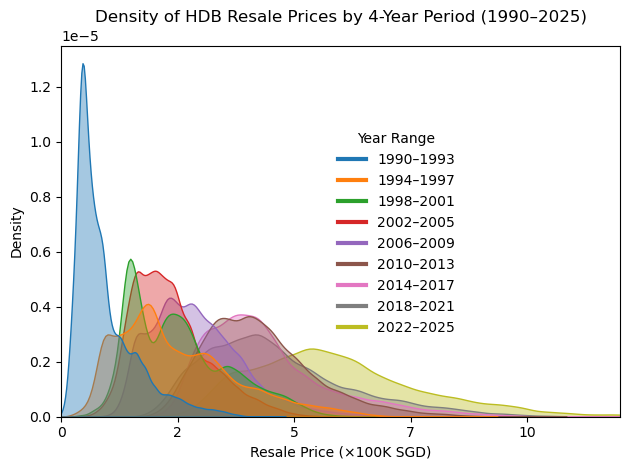

In [7]:
# --- Plot KDE ---
ax = sns.kdeplot(
    data=df,
    x="resale_price",
    hue="year_group",
    common_norm=False,
    fill=True,
    alpha=0.4,
    legend=True
)

# Format x-axis in 100K
xticks = plt.xticks()[0]
plt.xticks(xticks, [f"{int(x/100_000)}" for x in xticks])
plt.xlim(0, 1200000)
plt.title("Density of HDB Resale Prices by 4-Year Period (1990–2025)")
plt.xlabel("Resale Price (×100K SGD)")
plt.ylabel("Density")

# --- Build ordered legend ---
handles, labels = ax.get_legend_handles_labels()

# If legend missing, rebuild manually (robust fallback)
if not labels or all("year_group" in l for l in labels):
    palette = sns.color_palette(n_colors=len(year_groups_sorted))
    handles = [
        plt.Line2D([0], [0], color=palette[i], lw=3, label=str(year_groups_sorted[i]))
        for i in range(len(year_groups_sorted))
    ]
    labels = [str(g) for g in year_groups_sorted]

# Place legend at top, sorted chronologically
plt.legend(
    handles=handles,
    labels=labels,
    title="Year Range",
    loc="upper center",
    bbox_to_anchor=(0.6, 0.8),
    ncol=min(len(labels), 1),
    frameon=False
)

plt.tight_layout()
plt.savefig("figures/Resale_price_density_plot.pdf", dpi=300, bbox_inches='tight')
plt.show()


### Filtered Data required for model
Note that I am converting resale prices in log

In [8]:
def filter_data_for_modeling(clean_hdb_df, year_cutoff=2013):
    #defining features and target variable
    feature_df = pd.DataFrame({
   # "resale_date": clean_hdb_df["month"],
    "transaction_id": clean_hdb_df["transaction_id"],
    "resale_year": clean_hdb_df["month"].dt.year,
    "town": clean_hdb_df["town"],
    "flat_age": (clean_hdb_df["month"] - clean_hdb_df["lease_commence_date"]).dt.days / 365.25,
    "flat_type": clean_hdb_df["flat_type"],
    })
    #target_variable =pd.DataFrame({"resale_price": clean_hdb_df["resale_price"]})

    #spliting data into past and future based on year cutoff
    #features with ID
    past_feature_df=feature_df[feature_df["resale_year"] <= year_cutoff]
    future_feature_df=feature_df[feature_df["resale_year"] > year_cutoff]

    #targets with id and logged prices
    past_target_df = clean_hdb_df[clean_hdb_df["month"].dt.year <= year_cutoff][["transaction_id", "resale_price"]].copy()
    past_target_df["resale_price"] = np.log10(past_target_df["resale_price"])

    future_target_df = clean_hdb_df[clean_hdb_df["month"].dt.year > year_cutoff][["transaction_id","resale_price"]].copy()
    future_target_df["resale_price"] = np.log10(future_target_df["resale_price"])
    
    return past_feature_df, past_target_df, future_feature_df, future_target_df


    

In [9]:
past_feature_df, past_target_df, future_feature_df, future_target_df = filter_data_for_modeling(df, year_cutoff=2013)

In [10]:
print(len(past_feature_df))
print(len(past_target_df))
print(len(future_feature_df))
print(len(future_target_df))

692954
692954
269992
269992


In [11]:
# Split past data into training and validation sets (80/20)
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(
    past_feature_df, 
    past_target_df, 
    test_size=0.2,
    random_state=42,
    shuffle=True
)


### Prepare features for modeling

In [13]:
def prepare_features_sm(df, training_columns=None, drop_first=True):
    """
    Prepare features for training or prediction with column verification
    
    Parameters:
    -----------
    df : DataFrame with features
    training_columns : list, optional. If provided, align to these columns
    drop_first : bool, whether to drop first dummy variable
    
    Returns:
    --------
    X_dummies : DataFrame of processed features
    columns : list of column names
    ids : Series of transaction IDs (if present)
    """
    # Extract and save IDs before processing
    ids = df["transaction_id"].copy() if "transaction_id" in df.columns else None

    # Drop ID column from features
    feature_cols = [col for col in df.columns if col != "transaction_id"]
    df_features = df[feature_cols].copy()

    # Get dummies for categorical variables
    X_dummies = pd.get_dummies(df_features, drop_first=drop_first)
    
    # Verify and align columns if training_columns provided
    if training_columns is not None:
        # Check for missing columns
        missing_cols = set(training_columns) - set(X_dummies.columns)
        if missing_cols:
            print(f"Warning: Adding missing columns: {missing_cols}")
            for col in missing_cols:
                X_dummies[col] = 0
                
        # Check for extra columns that weren't in training
        extra_cols = set(X_dummies.columns) - set(training_columns)
        if extra_cols:
            print(f"Warning: Dropping columns not in training data: {extra_cols}")
            X_dummies = X_dummies.drop(columns=list(extra_cols))
        
        # Ensure exact column order
        X_dummies = X_dummies.reindex(columns=training_columns, fill_value=0)
        
        # Verify alignment
        assert set(X_dummies.columns) == set(training_columns), \
            "Column mismatch after alignment"
        assert X_dummies.columns.tolist() == training_columns, \
            "Column order mismatch after alignment"
    
    return X_dummies, X_dummies.columns.tolist(), ids

In [14]:
# TRAINING and TESTING Data
X_train, training_columns, train_ids = prepare_features_sm(X_train_df)
X_val, _, val_ids = prepare_features_sm(X_val_df, training_columns=training_columns)

y_train=y_train_df['resale_price']
y_val = y_val_df['resale_price']

# Verify alignment
assert len(train_ids) == len(y_train), "Training ID and target length mismatch!"
assert len(val_ids) == len(y_val), "Validation ID and target length mismatch!"


### Modeling

In [15]:

def apply_model_sm(X_train, Y_train):
    """
    Fit OLS regression model using statsmodels.
    
    Parameters:
    -----------
    X_train : DataFrame of training features
    Y_train : DataFrame of training target
    training_columns : list of column names (for reference)
    
    Returns:
    --------
    results_model1_sm : fitted model results
    """

    # Check for NaN values
    if X_train.isna().any().any() or Y_train.isna().any():
        raise ValueError("Input data contains NaN values")
    
    # Convert to numpy and add constant
    X_np = X_train.to_numpy()
    X = sm.add_constant(X_np) # Add intercept
    X = X.astype(float) #needed for statsmodels
    # Fit the ordinary least squares regression model

    Y=Y_train.to_numpy() 
    Y=Y.astype(float)

    model1_sm = sm.OLS(Y, X)
    results_model1_sm = model1_sm.fit()
    # Print the summary of regression results

    print(f"R2: {results_model1_sm.rsquared:.4f}")
    print(f"Result summary: {results_model1_sm.summary()}" )

    return results_model1_sm


Model Training

In [16]:

results_model1_sm=apply_model_sm(X_train, y_train)

R2: 0.7388
Result summary:                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                 4.611e+04
Date:                Wed, 29 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:32:55   Log-Likelihood:             3.4426e+05
No. Observations:              554363   AIC:                        -6.884e+05
Df Residuals:                  554328   BIC:                        -6.881e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -44.3228    

### Model Validation

In [17]:
# Make validation predictions
X_val_np = X_val.to_numpy()
X_val_with_const = sm.add_constant(X_val_np, has_constant='add')
val_predictions = results_model1_sm.predict(X_val_with_const)

In [18]:
# Calculate validation metrics
val_actual_price = np.power(10, y_val.values)
val_predicted_price = np.power(10, val_predictions)


In [19]:
val_rmse = np.sqrt(mean_squared_error(val_actual_price, val_predicted_price))
val_mape = np.mean(np.abs((val_actual_price - val_predicted_price) / val_actual_price)) * 100
val_r2 = r2_score(val_actual_price, val_predicted_price)


print("\nValidation Metrics:")
print(f"RMSE: ${val_rmse:,.2f}")
print(f"MAPE: {val_mape:.2f}%")#
print(f"R² Score: {val_r2:.4f}")


Validation Metrics:
RMSE: $73,300.57
MAPE: 24.33%
R² Score: 0.6915


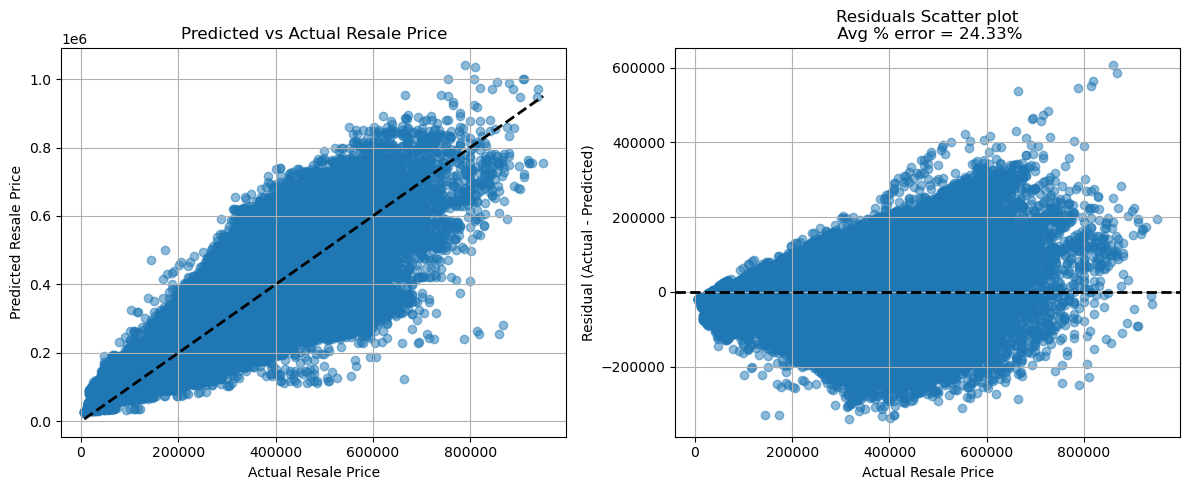

In [20]:
# Scatter plot: predicted vs actual resale prices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(val_actual_price, val_predicted_price , alpha=0.5)
plt.plot([val_actual_price.min(), val_actual_price.max()], [val_actual_price.min(), val_actual_price.max()], 'k--', lw=2)
plt.xlabel('Actual Resale Price')
plt.ylabel('Predicted Resale Price')
plt.title('Predicted vs Actual Resale Price')
plt.grid(True)

# RMSE as residual scatter plot
residuals = val_actual_price - val_predicted_price 

plt.subplot(1, 2, 2)
plt.scatter(val_actual_price, residuals, alpha=0.5, label='Residuals')
plt.axhline(0, color='k', lw=2, linestyle='--')
plt.xlabel('Actual Resale Price')
plt.ylabel('Residual (Actual - Predicted)')
#plt.ylabel('Percentage Residual (Actual - Predicted)')
#plt.title(f'Residuals Scatter plot\nRMSE = {val_rmse:.2f} SGD')
plt.title(f'Residuals Scatter plot\n Avg % error = {val_mape:.2f}%')
plt.grid(True)

plt.tight_layout()
plt.savefig("figures/OLS_test_viz.pdf", dpi=300, bbox_inches='tight')
plt.show()


### Future Predictions
For year 2014

In [21]:
merged_df = pd.merge(future_feature_df, future_target_df, on='transaction_id', how='inner')
merged_2014_df = merged_df[merged_df['resale_year'] == 2014]

#feature and target dfs
target_2014_df = merged_2014_df[['transaction_id', 'resale_price']].copy()
features_2014_df = merged_2014_df.drop(columns=['resale_price']).copy()


In [22]:
# 2. Test Phase- CRITICAL: Must match training columns exactly

X_future_dummies, _ , future_ids= prepare_features_sm(features_2014_df, training_columns=training_columns)

In [23]:
len(X_future_dummies)

16096

Prediction using trained model

In [24]:
#Model specific preparation for prediction
X_future_np = X_future_dummies.to_numpy()
#X_future = sm.add_constant(X_future_np)
X_future = sm.add_constant(X_future_np, has_constant='add')
X_future = X_future.astype(float)

# Make predictions
predictions = results_model1_sm.predict(X_future)
print("Done with predictions.")

Done with predictions.


Performance

In [25]:
# Safety check: Verify IDs match before using .values
assert (features_2014_df['transaction_id'].values == target_2014_df['transaction_id'].values).all(), \
    "Feature and target IDs don't match! Use ID-based merging instead."

In [26]:
actual_price = np.power(10, target_2014_df['resale_price'].values)
predicted_price = np.power(10, predictions)

results_df = pd.DataFrame({
    'transaction_id': future_ids,
    'actual_price': actual_price,
    'predicted_price': predicted_price,
    'error': actual_price - predicted_price,
    'abs_error': np.abs(actual_price - predicted_price),
    'pct_error': 100 * np.abs(actual_price - predicted_price) / actual_price
})


future_r2 = r2_score(actual_price, predicted_price)
future_mae=results_df['abs_error'].mean()
future_mpe=results_df['pct_error'].mean()
future_rmse=np.sqrt((results_df['error']**2).mean())


print("\nPrediction Results:")
print(results_df.head(5))
print(f"\nMean Absolute Error: ${future_mae:,.2f}")
print(f"Mean % Error: {future_mpe:.2f}%")
print(f"RMSE: ${future_rmse:,.2f}")#
print(f"R² Score: {future_r2:,.4f}")


Prediction Results:
        transaction_id  actual_price  predicted_price          error  \
216743          252851      280000.0    170699.613820  109300.386180   
216744          252852      290000.0    300444.989227  -10444.989227   
216745          252853      300000.0    298714.740008    1285.259992   
216746          252854      315000.0    300444.989227   14555.010773   
216747          252855      318000.0    300444.989227   17555.010773   

            abs_error  pct_error  
216743  109300.386180  39.035852  
216744   10444.989227   3.601720  
216745    1285.259992   0.428420  
216746   14555.010773   4.620638  
216747   17555.010773   5.520444  

Mean Absolute Error: $69,363.62
Mean % Error: 15.48%
RMSE: $89,489.42
R² Score: 0.4698


Visualize the predictions vs actuals

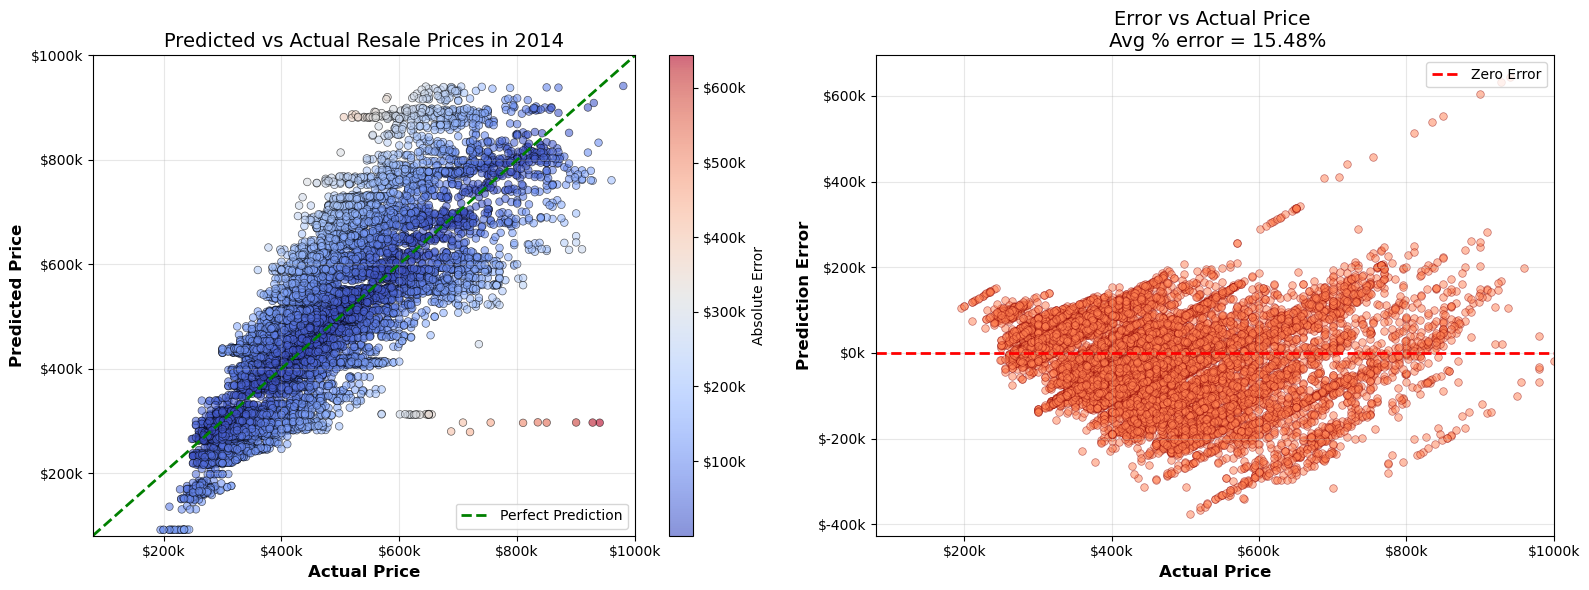

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sample
n = len(results_df) # 1000
sample_df = results_df.sample(n=n, random_state=42)

# 1. Predicted vs Actual (color by error)
ax = axes[0]
scatter = ax.scatter(
    sample_df['actual_price'], 
    sample_df['predicted_price'], 
    c=sample_df['abs_error'],
    cmap='coolwarm',
    alpha=0.6, 
    s=30,
    edgecolors='black', 
    linewidth=0.5
)
x = np.linspace(80000, 1000000, 100)
ax.plot(x, x, 'g--', linewidth=2, label='Perfect Prediction')
ax.set_ylabel("Predicted Price", fontsize=12, fontweight='bold')
ax.set_xlabel("Actual Price", fontsize=12, fontweight='bold')
#ax.set_title(f"Predicted vs Actual (n={n:,})", fontsize=14)
ax.set_title('Predicted vs Actual Resale Prices in 2014', fontsize=14)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'${y/1000:.0f}k'))
ax.grid(True, alpha=0.3)
ax.set_xlim(80000, 1000000)
ax.set_ylim(80000, 1000000)
ax.legend(loc='lower right')

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Absolute Error', fontsize=10)
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'${y/1000:.0f}k'))

# 2. Error vs Actual Price
ax = axes[1]
ax.scatter(sample_df['actual_price'], sample_df['error'], alpha=0.5, s=30, c='coral', edgecolors='darkred', linewidth=0.5)
ax.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax.set_xlabel("Actual Price", fontsize=12, fontweight='bold')
ax.set_ylabel("Prediction Error", fontsize=12, fontweight='bold')
ax.set_title(f"Error vs Actual Price \n Avg % error = {future_mpe:.2f}%", fontsize=14)
#plt.title(f'Residuals Scatter plot\n Avg % error = {val_mape:.2f}%')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'${y/1000:.0f}k'))
ax.grid(True, alpha=0.3)
ax.set_xlim(80000, 1000000)
#ax.set_xlim(0, 10)
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig("figures/OLS_forecast_viz.pdf", dpi=300, bbox_inches='tight')
plt.show()

### New Predictions

In [28]:
def predict_resale_price(model_results, training_columns,actual_df, flat_type, town, flat_age, resale_year=2014):
    """
    Predict resale price for a specific flat
    
    Parameters:
    -----------
    model_results : statsmodels results object
    training_columns : list of column names from training
    flat_type : str, e.g., '3 ROOM', '4 ROOM', '5 ROOM'
    town : str, e.g., 'ANG MO KIO', 'BEDOK'
    flat_age : float, age of flat in years
    resale_year : int, year of resale
    
    Returns:
    --------
    predicted_price : float
    """
    
    # Create input dataframe
    input_df = pd.DataFrame({
        #'transaction_id': [0],  # Dummy ID
        'resale_year': [resale_year],
        'town': [town],
        'flat_age': [flat_age],
        'flat_type': [flat_type]
    })
    print(input_df.shape)
    
    # Prepare features (same way as training)
    X_input_dummies, _, _ = prepare_features_sm(
        input_df, 
        training_columns=training_columns
        #id_column=None  # No ID needed for single prediction
    )

    #print(X_input_dummies.shape)
     
    X_input_np = X_input_dummies.to_numpy()
    #X_input = sm.add_constant(X_input_np) #this is somehow not working
    X_input = sm.add_constant(X_input_np, has_constant='add')
    X_input = X_input.astype(float)
    #print(X_input.shape)

    # Make prediction
    predicted_log_price = model_results.predict(X_input)
    predicted_price = 10**predicted_log_price


    # Find similar flats in actual data
    similar_flats = actual_df[
        (actual_df['flat_type'] == flat_type.upper()) &
        (actual_df['town'] == town.upper()) &
        (actual_df['flat_age'] >= flat_age - 2) &
        (actual_df['flat_age'] <= flat_age + 2) &
        (actual_df['resale_year'] == resale_year)
        #(actual_df['resale_year'] >= resale_year - 1) &
        #(actual_df['resale_year'] <= resale_year + 1)
    ]
    
    if len(similar_flats) > 0:
        print(f"\nSimilar Flats Found: {len(similar_flats)}")
        print(f"  Average Actual Price: ${10**(similar_flats['resale_price'].mean()):,.2f}")
        print(f"  Price Range: ${10**(similar_flats['resale_price'].min()):,.2f} - ${10**(similar_flats['resale_price'].max()):,.2f}")
        print(f"  Median: ${10**(similar_flats['resale_price'].median()):,.2f}")
    else:
        print("\nNo similar flats found in dataset")
    

    return predicted_price, similar_flats




In [29]:
# Example prediction
predicted_price, similar_flats = predict_resale_price(
    model_results=results_model1_sm,
    training_columns=training_columns,
    #id=None
    flat_type='4 ROOM',
    town='BEDOK',
    flat_age=25,
    resale_year=2014,
    actual_df=pd.merge(future_feature_df, future_target_df, on='transaction_id', how='inner')
)

print(f"\nPredicted Resale Price: {predicted_price[0]:.2f}")

(1, 4)

Similar Flats Found: 4
  Average Actual Price: $445,577.01
  Price Range: $400,000.00 - $598,000.00
  Median: $405,942.90

Predicted Resale Price: 91675.14


## Possible causes of large errors in prediction

1-Time trend / sample cutoff: training data ≤2013 is lower-priced than later years (bias when predicting 2014+).

2- Small sample of high priced flats, thus very large errors in high priced flats

3- Nonlinearity / heteroscedasticity: linear OLS may not capture price relationships (e.g., log‑price, interactions).

